<a href="https://colab.research.google.com/github/CanKeles5/Predict-NG/blob/main/TEIA%C5%9E_LSTM_predict_NG_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.cuda.is_available()
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

In [2]:
device

device(type='cpu')

In [3]:
%matplotlib inline

In [4]:
! pip install pickle5

     |████████████████████████████████| 133kB 5.0MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219275 sha256=ad12cd897a928f2f586be3b49d74d7bdbe7cf258d24483b862d1ea10a76a9068
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [5]:
import pickle5
from math import sqrt
from datetime import datetime
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
with open('/content/20210101-epias-raw.pkl', 'rb') as f:
    data = pickle5.load(f)

Drop all colums of zeros: df.loc[:, (df != 0).any(axis=0)]


In [7]:
new_data = data.loc[:, (data != 0).any(axis=0)] #(index=False)

In [8]:
new_data.shape

(67268, 24)

In [9]:
new_data = new_data[0:67268-24*300]

In [10]:
new_data.shape

(60068, 24)

In [11]:
new_data

,date,fueloil,blackCoal,lignite,geothermal,naturalGas,river,dammedHydro,lng,biomass,naphta,importCoal,asphaltiteCoal,wind,sun,importExport,total,ltotal,lwind,lbiogas,lcanalType,lbiomass,lsun,lothers
0,2013-05-01 00:00:00,29.2,0.00,551.00,0.00,2326.01,151.49,502.38,9.3,26.35,0.0,1184.00,0.00,2.00,0.0,0.0,4781.73,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2013-05-01 01:00:00,29.1,0.00,544.00,0.00,2334.78,152.77,441.94,9.3,27.07,0.0,1184.00,0.00,2.00,0.0,0.0,4724.96,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,2013-05-01 02:00:00,29.1,0.00,547.00,0.00,2157.76,151.47,430.19,9.3,26.88,0.0,1185.00,0.00,2.00,0.0,0.0,4538.70,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,2013-05-01 03:00:00,29.0,0.00,547.00,0.00,2084.72,125.83,275.18,9.4,25.67,0.0,1183.00,0.00,1.00,0.0,0.0,4280.80,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,2013-05-01 04:00:00,28.3,0.00,549.00,0.00,2034.68,124.35,271.86,9.4,26.45,0.0,1066.00,0.00,1.00,0.0,0.0,4111.04,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60063,2020-03-07 19:00:00,36.1,280.96,4351.81,1085.50,1819.41,4371.78,11958.95,0.0,458.16,0.0,7990.04,339.04,2971.57,0.0,239.0,35902.32,52.2281,13.2950,16.9841,4.1684,14.4191,3.0673,0.2942
60064,2020-03-07 20:00:00,35.7,285.53,4349.41,1100.85,1809.92,4341.69,11481.08,0.0,459.27,0.0,7983.78,340.02,2968.33,0.0,163.0,35318.58,48.6524,13.1804,16.9642,4.0431,13.9582,0.3931,0.1134
60065,2020-03-07 21:00:00,36.2,301.52,4360.10,1107.39,1749.12,4336.44,10677.39,0.0,464.02,0.0,7975.81,335.60,3013.95,0.0,169.0,34526.54,48.5306,13.3514,16.9729,3.9932,13.7144,0.3676,0.1311
60066,2020-03-07 22:00:00,36.4,307.80,4052.46,1115.12,1651.82,4313.39,9225.29,0.0,455.99,0.0,7968.84,335.60,3179.01,0.0,98.0,32739.72,49.5955,14.2639,16.9540,4.1900,13.7055,0.3663,0.1158


In [12]:
new_data = new_data.sample(frac = 1) #shuffles the rows.

In [13]:
new_data = new_data.drop(['date', 'ltotal',	'lwind',	'lbiogas',	'lcanalType',	'lbiomass',	'lsun',	'lothers', 'total'], axis=1)

In [14]:
new_data

,fueloil,blackCoal,lignite,geothermal,naturalGas,river,dammedHydro,lng,biomass,naphta,importCoal,asphaltiteCoal,wind,sun,importExport
13210,237.50,321.00,4187.72,305.20,10989.19,1703.08,1165.54,7.0,116.57,0.0,4770.86,0.00,1656.73,0.00,0.00
22562,188.40,343.50,3487.32,421.07,9950.62,655.03,2329.28,9.2,142.49,0.0,5325.02,268.68,1535.45,0.00,0.00
49244,225.00,368.00,5370.46,854.37,10495.30,2699.17,2731.69,0.0,309.24,0.0,7768.14,362.10,1182.06,0.00,-397.28
26837,250.87,198.50,4109.11,497.02,8700.53,3736.65,7919.02,9.2,171.29,0.0,5442.18,269.36,1227.12,0.00,0.00
25719,208.24,343.50,2924.84,452.05,11407.07,3693.31,7675.70,8.7,173.82,0.0,4128.28,404.05,511.91,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28815,189.30,340.50,4318.79,459.89,11460.96,1172.21,6351.78,8.7,174.97,0.0,5176.45,86.11,4026.36,0.00,0.00
16329,294.80,346.50,3662.79,340.19,13225.50,3996.05,6368.00,9.6,137.62,0.0,5134.90,134.68,605.34,0.00,0.00
49138,217.80,367.50,4905.53,907.52,10536.87,1971.84,7460.53,0.0,296.76,0.0,7265.69,337.81,535.29,26.13,-365.25
58984,36.90,270.75,4723.95,1153.48,11270.67,1630.92,9620.23,0.0,420.47,0.0,8474.60,337.81,1724.29,0.00,-267.00


In [15]:
target = new_data.drop(['fueloil',	'blackCoal',	'lignite',	'geothermal',	'river',	'dammedHydro',	'lng',	'biomass',	'naphta',	'importCoal',	'asphaltiteCoal',	'wind',	'sun',	'importExport'], axis=1)

In [16]:
target = target.to_numpy()

In [17]:
data = new_data.drop(['naturalGas'], axis=1)

In [18]:
data = data.to_numpy()

To-do:
  Get the data in such a format that it can work with the other notebook.
  
  1- Extract the date element.

  2- Normalize all features in the input part of the data.

  3- Create the inputs and the targets.

  4- Create train and test sets.

  5- 

  6- 

In [19]:
# integer encode direction
#encoder = LabelEncoder()
#new_data[:,4] = encoder.fit_transform(new_data[:,4])
# ensure all data is float

#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
target = scaler.fit_transform(target)

print(data.shape)
print(target.shape)
#reframed = series_to_supervised(scaled, n_hours, 1)
#print(reframed.shape)

(60068, 14)
(60068, 1)


In [20]:
train_x = data[0:42000]
train_y = target[0:42000]

val_x = data[42000:54000]
val_y = target[42000:54000]

test_x = data[54000:60068]
test_y = target[54000:60068]

In [29]:
bs = 128

In [50]:
class LSTM(nn.Module):

  def __init__(self):
    super(LSTM, self).__init__()

    self.lstm = nn.LSTM(input_size=14, hidden_size=300, num_layers=3)
    self.FC = nn.Linear(300*bs, bs)

  def forward(self, input):
    pred, _ = self.lstm(input)

    pred = self.FC(pred.view(300*bs))

    return pred

In [51]:
model = LSTM().to(device)

In [52]:
sum(p.numel() for p in model.parameters())

6739328

In [53]:
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [54]:
train_loss_hist = []
val_loss_hist = []

In [55]:
for epoch in range(20):
  train_loss = 0.0
  val_loss = 0.0

  for i in range(int(train_x.shape[0]/bs)):
    data = torch.Tensor(train_x[i*bs: i*bs+bs: ,]).unsqueeze(0) #.unsqueeze(0)    
    data = data.to(device)

    model.train()
    optimizer.zero_grad()

    prediction = model(data)

    #print("Train --- prediction: " + str(prediction) + " , GT: " + str(train_y[i]))

    loss = loss_function(prediction, torch.Tensor([train_y[i*bs: i*bs+bs : ,]]).to(device))

    train_loss += loss.item()

    loss.backward()
    optimizer.step()
  
  with torch.no_grad():
    for i in range(int(val_x.shape[0]/bs)):
      data = torch.Tensor(val_x[i*bs: i*bs+bs: ,]).unsqueeze(0) #.unsqueeze(0)
      data = data.to(device)

      prediction = model(data)

      #print("Validate --- prediction: " + str(prediction) + " , GT: " + str(val_y[i]))

      loss = loss_function(prediction, torch.Tensor([val_y[i*bs: i*bs+bs: ,]]).to(device))
      val_loss += loss.item()

  train_loss = train_loss / train_x.shape[0]
  val_loss = val_loss / val_x.shape[0]

  train_loss_hist.append(train_loss)
  val_loss_hist.append(val_loss)
  
  print("Epoch " + str(epoch) + " ---> Train loss: " +  str(train_loss) + " --- Validation loss: " + str(val_loss))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1, 128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0 ---> Train loss: 0.0014488208950275466 --- Validation loss: 0.0010423953750481208
Epoch 1 ---> Train loss: 0.0010429043533901373 --- Validation loss: 0.0010425105908264717
Epoch 2 ---> Train loss: 0.0010430290124246052 --- Validation loss: 0.001042417069276174
Epoch 3 ---> Train loss: 0.0010430770177571546 --- Validation loss: 0.0010421771655480068
Epoch 4 ---> Train loss: 0.0010431449131241867 --- Validation loss: 0.0010421029664576054
Epoch 5 ---> Train loss: 0.0010432426739661466 --- Validation loss: 0.0010420597903430461
Epoch 6 ---> Train loss: 0.0010432491902084577 --- Validation loss: 0.001042065064733227
Epoch 7 ---> Train loss: 0.001043250560050919 --- Validation loss: 0.0010420606049398582
Epoch 8 ---> Train loss: 0.0010432779845737275 --- Validation loss: 0.0010420581040283044
Epoch 9 ---> Train loss: 0.0010433033239983377 --- Validation loss: 0.0010420688806722562
Epoch 10 ---> Train loss: 0.0010433010661176274 --- Validation loss: 0.0010420620286216338
Epoch 11 ---

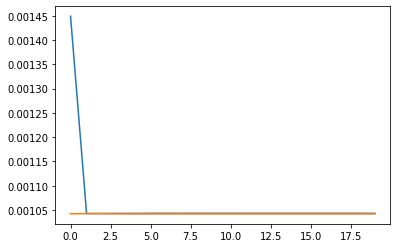

In [56]:
pyplot.plot(train_loss_hist)
pyplot.plot(val_loss_hist)

In [155]:
max_error = 0.0 #store the maximum difference between ground truth and prediction.

In [156]:
errors = []

In [ ]:
test_loss = 0.0

with torch.no_grad():
  for i in range(int(test_x.shape[0]/bs)):
    data = torch.Tensor(test_x[i*bs: i*bs+bs: ,]).unsqueeze(0)#.unsqueeze(0)
    data = data.to(device)

    prediction = model(data)

    #print(torch.Tensor(test_y[i*bs: i*bs+bs: ,]).squeeze(1).shape)

    abs_diff = torch.abs(torch.sub(prediction, torch.Tensor(test_y[i*bs: i*bs+bs: ,]).squeeze(1)))
    max_ind =  torch.argmax(abs_diff)

    print(type(abs(prediction[0]-test_y[i*bs: i*bs+bs: ,][0]).item()))

    for j in range(bs):
      errors.append(abs(prediction[j]-test_y[i*bs: i*bs+bs: ,][j]).item())


    if abs_diff[max_ind] > max_error:
      max_error = abs_diff[max_ind]

    #print("Validate --- prediction: " + str(prediction) + " , GT: " + str(val_y[i]))

    loss = loss_function(prediction, torch.Tensor([test_y[i*bs: i*bs+bs: ,]]).to(device))
    test_loss += loss.item()

In [158]:
test_x.shape

(6068, 14)

In [159]:
print("Test loss is: " + str(test_loss/test_y.shape[0]))

Test loss is: 0.0010269698818891396


In [160]:
print("Maximum error on test set is: " + str(max_error))

Maximum error on test set is: tensor(0.5032)


In [162]:
test_x.shape[0]

6068

In [173]:
len(errors)

6016

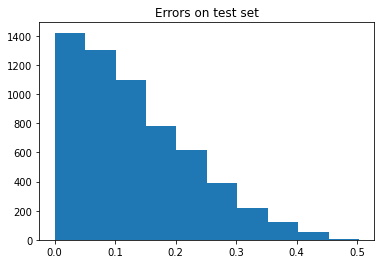

In [174]:
from matplotlib import pyplot as plt 

plt.hist(errors)
plt.title("Errors on test set")
plt.show()